In [1]:
from shapely.geometry.polygon import LinearRing, Polygon
from descartes import PolygonPatch
from matplotlib import pyplot as plt
from shapely.geometry.polygon import Polygon

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys
sys.path.append('../scripts/')
import cv2
import matplotlib.patches as patches
import math
import scipy
from scipy.ndimage.morphology import binary_closing
from scipy import ndimage
from IPython.display import SVG 
from IPython.display import Pretty 
import pprint
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
from icon_helper_functions import *

In [4]:
from IPython.display import SVG

In [5]:
from collections import Counter
from itertools import groupby
from scipy.stats import norm
from scipy.stats import t
import math
from planar import Polygon as planar_polygon
from scipy.integrate import quad
import warnings
from functools import partial
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Reading polygon information

In [6]:
first_polygons = []
second_polygons = []
file_list = []
SVGs_path = '../outputs/clear_bricklayer_hammer_SVGs/'
all_svgs = os.listdir(SVGs_path)
for i in range(len(all_svgs)):
    curr_svg = all_svgs[i]
    if curr_svg.startswith('.'):
        pass
    else:
        curr_svg_path = SVGs_path + curr_svg
        file_list.append(curr_svg_path)
        f = open(curr_svg_path,'r')
        content = f.readlines()
        f.close()
        polygon_ct = 0
        for c in content:
            c = c.rstrip()
            if c.startswith('<polygon'):
                points = c.split('="')[1].split('"')[0].split(' ')
                tup_points = []
                for point in points:
                    x,y = point.split(',')
                    tup = (int(x),200-int(y))
                    tup_points.append(tup)
                if polygon_ct == 0:
                    first_polygons.append(tup_points)
                elif polygon_ct == 1:
                    second_polygons.append(tup_points)
                else:
                    print('More than 2 polygons detected!')
                polygon_ct += 1

In [35]:
def plot_svg(polygons):
    fig = plt.figure(1, figsize=(5,5), dpi=90)
    ax = fig.add_subplot(111)
    for polygon in polygons:
        ring_mixed = Polygon(polygon)
        ring_patch = PolygonPatch(ring_mixed)
        ax.add_patch(ring_patch)
        for (x,y) in polygon:
            ax.plot(x,y,'ro')
            ax.annotate('(%s,%s)'%(x,y), xy=(x, y), xytext=(x, y))
    xrange = [0, 200]
    yrange = [0, 200]
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.set_aspect(1)

In [36]:
def plot_svg_big(polygons):
    fig = plt.figure(1, figsize=(10,10), dpi=90)
    ax = fig.add_subplot(111)
    for polygon in polygons:
        ring_mixed = Polygon(polygon)
        ring_patch = PolygonPatch(ring_mixed)
        ax.add_patch(ring_patch)
        for (x,y) in polygon:
            ax.plot(x,y,'ro')
            ax.annotate('(%s,%s)'%(x,y), xy=(x, y), xytext=(x, y))
    xrange = [-250, 250]
    yrange = [-250, 250]
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.set_aspect(1)

# Lets look at a random polygon

[(28, 136), (44, 168), (60, 183), (75, 190), (112, 192), (126, 184), (134, 189), (160, 189), (170, 180), (168, 138), (163, 134), (133, 134), (126, 138), (122, 121), (82, 124), (81, 141), (72, 149), (52, 144), (38, 131), (32, 131)]


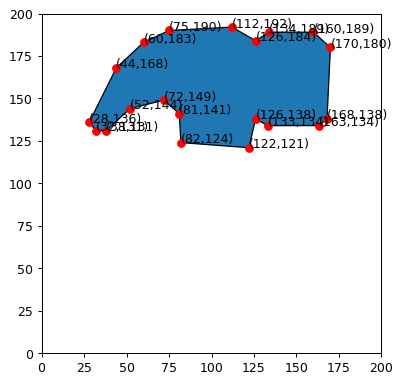

In [37]:
ID = 25
plot_svg([second_polygons[ID]])
print(second_polygons[ID])

# Picking instances of polygons that occur enough

In [38]:
sides_to_polygons = {}
for polygon in second_polygons:
    (x0,y0) = polygon[0]
#     translated_polygon = [(x-x0,y-y0) for (x,y) in polygon]
    translated_polygon = polygon
    if len(polygon) in sides_to_polygons.keys():
        sides_to_polygons[len(polygon)].append(translated_polygon)
    else:
        sides_to_polygons[len(polygon)] = [translated_polygon]

In [39]:
retained_polygon_dict = {}
for side_length in sides_to_polygons.keys():
    num_polygons = len(sides_to_polygons[side_length])
    fraction = num_polygons/float(len(second_polygons))
    if  fraction < 0.075:
        pass
    else:
        retained_polygon_dict[side_length] = sides_to_polygons[side_length]

In [40]:
for key,value in retained_polygon_dict.items():
    print("Number of instances with %s sides: %s"%(key,len(value)))

Number of instances with 8 sides: 8
Number of instances with 22 sides: 8
Number of instances with 20 sides: 11
Number of instances with 15 sides: 9


# Sampling the number of sides of the polygon

In [41]:
# Binary search to find optimal insert index in a sorted array (used later during sampling)
def index(seq, item):
    """Returns the index of an item in an increasingly-sorted
       sequence (if exists) otherwise returns the index where
       it would be inserted, using binary search.

       seq: a sequence.

       precondition: seq is sorted increasingly.
       """
    # Updates the sequence with the item using a
    # set to avoid duplicates.
    seq = set(seq)
    seq.update([item])

    # Converts the sequence to a list and re-sorts it. 
    sorted_seq = sorted(seq)

    middle = len(sorted_seq) // 2
    middle_value = sorted_seq[middle]

    first_half = sorted_seq[:middle]
    second_half = sorted_seq[middle:]

    if item == middle_value:
        return middle

    elif item < middle_value:
        return index(first_half, item)

    elif item > middle_value:
        return index(second_half, item) + len(first_half)

In [42]:
def num_sides_sampler(polygon_dict):
    sides = []
    freqs = []
    
    total = 0
    for key,value in retained_polygon_dict.items():
        sides.append(key)
        freqs.append(len(value))
        total += len(value)
    
    probs = [x/float(total) for x in freqs]
    
    cum_probs = []
    cum_prob = 0
    for prob in probs:
        cum_prob += prob
        cum_probs.append(cum_prob)
    np.random.seed(5)
    rand_num = np.random.uniform(0,1)
    rand_index = index(cum_probs,rand_num)
    sampled_side = sides[rand_index]
    return sampled_side

In [43]:
sampled_sides = num_sides_sampler(retained_polygon_dict)
print('Sampled sides - ',sampled_sides)

Sampled sides -  8


# Let's look at 8 sided polygons for now

In [44]:
eight_sided_polygons = retained_polygon_dict[8]

In [53]:
# # Visualizing eight sided polygons
# f, ax = plt.subplots(3, sharex=False, sharey=False)
# # ct = 0
# # for ax in axarr:
# #     polygon = eight_sided_polygons[ct]
# #     ring_mixed = Polygon(polygon)
# #     ring_patch = PolygonPatch(ring_mixed)
# #     ax.add_patch(ring_patch)
# # # ct = 0
# for row in ax:
#     for col in row:
#         plot_svg([eight_sided_polygons[ct]])
#         plt.axis('off')
#         plt.show()
#         ct += 1

In [54]:
def side_len(p2,p1):
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

#newest_version
def side_angle(pt1,pt2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'    """
    angle = np.arctan2(pt2[1] - pt1[1], pt2[0] - pt1[0])
    angle = (angle + 2*math.pi) % 2*math.pi
    return angle

# new version
# def side_angle(p2,p1):
#     if p2[0] == p1[0]:
#         if p2[1] > p1[1]:
#             angle = math.radians(90)
#         elif p2[1] < p1[1]:
#             angle = math.radians(270)
    
#     else:
#         slope = (p2[1]-p1[1])/(p2[0]-p1[0])
#         angle = math.atan(slope)
#         if angle <= 0:
#             angle += 2*math.pi
#     return angle
# side_angle(pol0[0],pol0[1])

# Basic approach sampling each side and angle as a gaussian
### UPDATE: Didn't work. Working on better one now.

In [55]:
# Storing frequency counts for lengths and angles of the polygons

In [56]:
lens = {}
angles = {}
for polygon in eight_sided_polygons:
    for side_ct in range(len(polygon)-1):
        next_pt = polygon[side_ct + 1]
        curr_pt = polygon[side_ct]
        length = side_len(next_pt,curr_pt)
        angle = side_angle(next_pt,curr_pt)
        
        if side_ct in lens.keys():
            lens[side_ct].append(length)
            angles[side_ct].append(angle)
        else:
            lens[side_ct] = [length]
            angles[side_ct] = [angle]

In [57]:
# Fitting distributions: right now, fitting normal dist to each side and angle.

In [58]:
mu_lengths = {}
std_lengths = {}
mu_angles = {}
std_angles = {}
for side_ct in lens.keys():
    # For side lengths
    lengths = lens[side_ct]
    mu_len, std_len = norm.fit(lengths)
    mu_lengths[side_ct] = mu_len
    std_lengths[side_ct] = std_len
    
    # For side angles
    angle = angles[side_ct]
    mu_ang, std_ang = norm.fit(angle)
    mu_angles[side_ct] = mu_ang
    std_angles[side_ct] = std_ang

In [59]:
# Sampling from distributions

In [60]:
sampled_points = [(0,0)]
for i in range(len(eight_sided_polygons[0])-1):
    side_leng = np.random.normal(mu_lengths[i],std_lengths[i])
    side_angl = np.random.normal(mu_angles[i],std_angles[i])
#     print('Side Length:',side_len)
#     print('Side Angle:',side_angle)
    curr_x,curr_y = sampled_points[-1]
    next_x = curr_x + int(50*math.cos(side_angl))
    next_y = curr_y + int(50*math.sin(side_angl))
    sampled_points.append((next_x,next_y))
print(sampled_points)

[(0, 0), (-44, -23), (-20, -66), (-47, -107), (-92, -128), (-43, -120), (-60, -73), (-15, -52)]


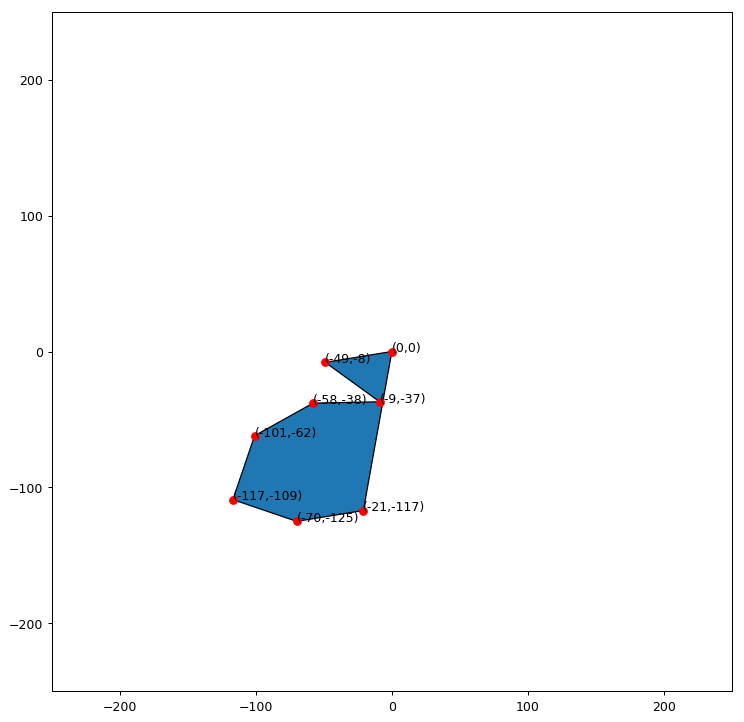

In [1286]:
poly = planar_polygon(sampled_points)
plot_svg_big([sampled_points])

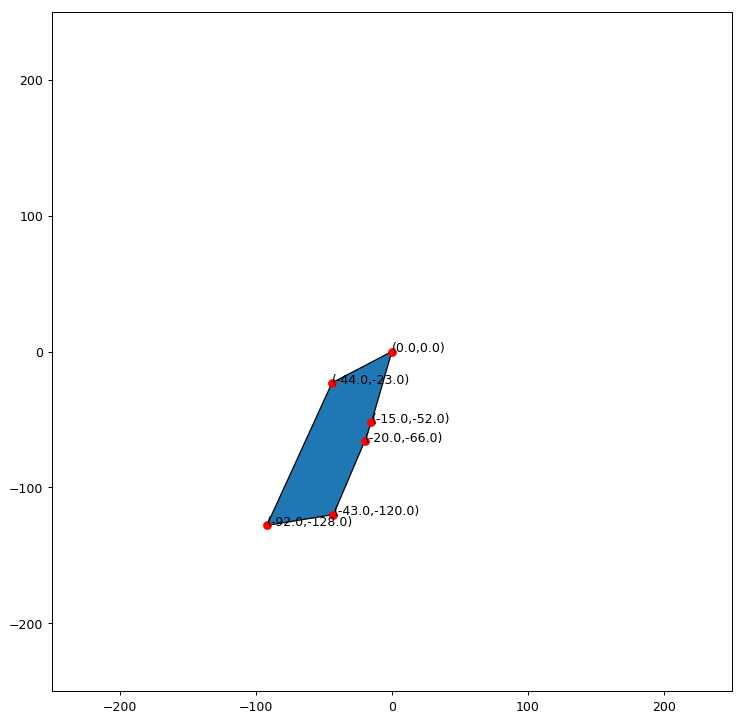

In [62]:
# Looks bad, so lets fit a convex hull to these points
poly_hull = planar_polygon.convex_hull(sampled_points)
# poly = Polygon(poly)
plot_svg_big([poly_hull])
# print(second_polygons[ID])

# This simple approach did not work.

## Before trying something more fancy, let's code a way to at least quantify the distance between two such polygons. One way is turning function.

In [63]:
# pol_2 = eight_sided_polygons[2]
# pol_3 = eight_sided_polygons[3]

In [64]:
# plot_svg([pol_3])

In [65]:
def polygon_perimeter(polygon):
    perimeter = 0
    for i in range(len(polygon)):
        curr_pt = polygon[i]
        if i != len(polygon)-1:
            next_pt = polygon[i+1]
        else:
            next_pt = polygon[0] # circle to original point
        length = side_len(next_pt,curr_pt)
        perimeter += length
    return perimeter

In [93]:
def piecewise(x, cum_lens,turnings):
    return np.piecewise(x, [x <= cum_lens[0], cum_lens[0] <= x <= cum_lens[1],cum_lens[1]<= x <= cum_lens[2],cum_lens[2]<= x <= cum_lens[3],cum_lens[3] <= x <= cum_lens[4],cum_lens[4] <= x <= cum_lens[5], cum_lens[5]<= x <= cum_lens[6], cum_lens[6] <= x <= 1],turnings,[0,1])

In [94]:
# def turning_function_debug(polygon):
#     perimeter = polygon_perimeter(polygon)
#     cum_angle = 0
#     lens = []
#     cum_angs = []
#     cum_lens = []
#     cum_length = 0
#     for i in range(len(polygon)):
#         curr_pt = polygon[i]
#         if i == 0:
#             first_point = curr_pt
#         if i != len(polygon)-1:
#             next_pt = polygon[i+1]
#         else:
#             next_pt = polygon[0] # circle to original point
#         length = side_len(next_pt,curr_pt)
#         normalized_length = length/float(perimeter)
#         angle = side_angle(next_pt,curr_pt)
#         cum_angle += angle
#         cum_length += normalized_length
#         cum_lens.append(cum_length)
#         cum_angs.append(angle)
    
#     return cum_lens,cum_angs,first_point

In [95]:
# def turning_function(polygon):
#     perimeter = polygon_perimeter(polygon)
#     cum_angle = 0
#     lens = []
#     cum_angs = []
#     cum_lens = []
#     cum_length = 0
#     for i in range(len(polygon)):
#         curr_pt = polygon[i]
#         if i == 0:
#             first_point = curr_pt
#         if i != len(polygon)-1:
#             next_pt = polygon[i+1]
#         else:
#             next_pt = polygon[0] # circle to original point
#         length = side_len(next_pt,curr_pt)
#         normalized_length = length/float(perimeter)
#         angle = side_angle(next_pt,curr_pt)
#         cum_angle += angle
#         cum_length += normalized_length
#         cum_lens.append(cum_length)
#         cum_angs.append(angle)
        
    
#     return partial(piecewise,cum_lens= cum_lens, cum_angs = cum_angs)

In [96]:
# def side_angle(pt1,pt2):
#     """ Returns the angle in radians between vectors 'v1' and 'v2'    """
#     angle = np.arctan2(pt2[1] - pt1[1], pt2[0] - pt1[0])
#     angle = (angle + 2*math.pi) % 2*math.pi
#     return angle

In [97]:
def check_clockwise(polygon):
    shoelace = 0
    for i in range(len(polygon)):
        curr_pt = polygon[i]
        if i != len(polygon)-1:
            next_pt = polygon[i+1]
        else:
            next_pt = polygon[0] # circle to original point
        shoelace += (next_pt[0] - curr_pt[0])*(next_pt[1] + curr_pt[1])
#         print(shoelace)
    if shoelace > 0:
        return True
    else:
        return False

In [98]:
pol0 = eight_sided_polygons[0]
pol1 = eight_sided_polygons[1]
pol2 = eight_sided_polygons[2]
pol7 = eight_sided_polygons[7]

[(38, 169), (77, 171), (79, 191), (120, 191), (122, 171), (160, 170), (160, 117), (39, 116)]
True


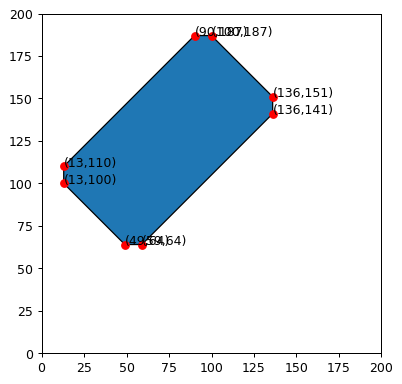

In [99]:
plot_svg([pol0])
print(pol1)
print(check_clockwise(pol1))

[(100, 187), (136, 151), (136, 141), (59, 64), (49, 64), (13, 100), (13, 110), (90, 187)]
True


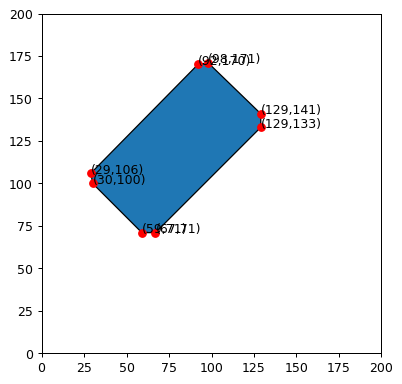

In [100]:
plot_svg([pol7])
print(pol0)
print(check_clockwise(pol0))

In [106]:
def poly_flip(polygon):
    new_polygon = [polygon[0]]
    new_polygon.extend(polygon[::-1][:-1])
    return new_polygon

In [107]:
def angle_3_vertices(pt1,pt2,pt3):
    A = np.array(pt2)-np.array(pt1)
    B = np.array(pt2)-np.array(pt3)
    an = np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))
    angle = np.arccos(an)*180/np.pi
    return angle

In [108]:
# Checking if the move was left is as easy as making a polygon of these points and checking if it's anti-clockwise or not.
# If clockwise: move was right, if anticlockwise: move was left.
def check_if_left_move(pt1,pt2,pt3):
    if check_clockwise([pt1,pt2,pt3]):
        return False
    else:
        return True

In [169]:
def turning_function_debug(polygon,RETURN=False):
    perimeter = polygon_perimeter(polygon)
    cum_lens = []

    if check_clockwise(polygon):
        polygon = poly_flip(polygon)
    poly_new = polygon + polygon[:2]
    
    turnings = []
    for i in range(len(poly_new)-2):
        pt1 = poly_new[i]
        pt2 = poly_new[i+1]
        pt3 = poly_new[i+2]
        
        # Lengths
        length_of_side = side_len(pt1,pt2)
        normalized_length = length_of_side/float(perimeter)
        cum_lens.append(normalized_length)
        
        internal_angle = angle_3_vertices(pt1,pt2,pt3)
        angle_of_importance = 180 - internal_angle
        if i == 0:
            start_angle = np.arctan2(pt2[1] - pt1[1], pt2[0] - pt1[0]) * 180/np.pi
            if start_angle < 0:
                start_angle += 360
            turning_val = start_angle
            turnings.append(turning_val)
            if RETURN == False:
                print(pt1,pt2,pt3,turning_val)
        # if movement was left: increase angle by external angle
        if check_if_left_move(pt1,pt2,pt3):
            turning_val += angle_of_importance
            turnings.append(turning_val)
            if RETURN == False:
                print(pt1,pt2,pt3,turning_val)
        else:
            turning_val -= angle_of_importance
            turnings.append(turning_val)
            if RETURN == False:
                print(pt1,pt2,pt3,turning_val)
    if RETURN == True:
        return cum_lens,turnings

In [170]:
def turning_function(polygon):
    perimeter = polygon_perimeter(polygon)
    cum_lens = []
    
    if check_clockwise(polygon):
        polygon = poly_flip(polygon)
    poly_new = polygon + polygon[:2]
    
    turnings = []
    for i in range(len(poly_new)-2):
        pt1 = poly_new[i]
        pt2 = poly_new[i+1]
        pt3 = poly_new[i+2]
        
        
        # Lengths
        length_of_side = side_len(pt1,pt2)
        normalized_length = length_of_side/float(perimeter)
        cum_lens.append(normalized_length)
        
        
        # Angles
        internal_angle = angle_3_vertices(pt1,pt2,pt3)
        angle_of_importance = 180 - internal_angle
        if i == 0:
            start_angle = np.arctan2(pt2[1] - pt1[1], pt2[0] - pt1[0]) * 180/np.pi
            if start_angle < 0:
                start_angle += 360
            turning_val = start_angle
            turnings.append(turning_val)
        # if movement was left: increase angle by external angle
        if check_if_left_move(pt1,pt2,pt3):
            turning_val += angle_of_importance
            turnings.append(turning_val)
        else:
            turning_val -= angle_of_importance
            turnings.append(turning_val)
    
    return partial(piecewise,cum_lens = cum_lens, turnings = turnings)

In [171]:
turning_function_debug(pol0)

(100, 187) (90, 187) (13, 110) 180.0
(100, 187) (90, 187) (13, 110) 225.0
(90, 187) (13, 110) (13, 100) 270.0
(13, 110) (13, 100) (49, 64) 315.0
(13, 100) (49, 64) (59, 64) 360.0
(49, 64) (59, 64) (136, 141) 405.0
(59, 64) (136, 141) (136, 151) 450.0
(136, 141) (136, 151) (100, 187) 495.0
(136, 151) (100, 187) (90, 187) 540.0


In [172]:
turning_function_debug(pol0,True)

([0.02780772785188952,
  0.302810707175301,
  0.02780772785188952,
  0.14157383712091998,
  0.02780772785188952,
  0.302810707175301,
  0.02780772785188952,
  0.14157383712091998],
 [180.0, 225.0, 270.0, 315.0, 360.0, 405.0, 450.0, 495.0, 540.0])

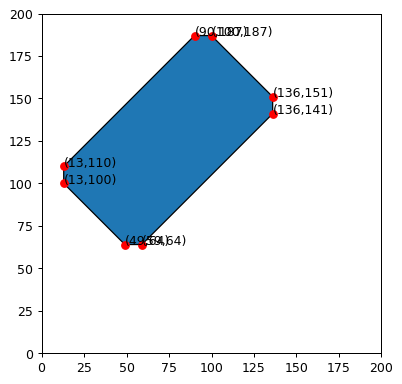

In [135]:
plot_svg([pol0])

In [136]:
# def polygon_distance(pol_1,pol_2):
#     integral_1 = quad(turning_function(pol_1),0,1)[0]
#     integral_2 = quad(turning_function(pol_2),0,1)[0]
#     integral_3 = quad(turning_function(poly_flip(pol_2)),0,1)[0] # check both orientations of polygons
#     return min(abs(integral_1 - integral_2),abs(integral_1-integral_3))

# def polygon_distance(pol_1,pol_2):
#     integral_1 = quad(turning_function(pol_1),0,1)[0]
#     integral_2 = quad(turning_function(pol_2),0,1)[0]
#     return abs(integral_1 - integral_2)

In [137]:
# polygon_distance(eight_sided_polygons[7],eight_sided_polygons[0])

In [138]:
# for i in range(len(eight_sided_polygons)):
#     for j in range(i):
#         pol_1 = eight_sided_polygons[i]
#         pol_2 = eight_sided_polygons[j]       
#         dist = polygon_distance(pol_1,pol_2)
#         if dist < 0.5:
#             print("%s,%s are a pair"%(i,j))
#             plot_svg_big([pol_1])
#             plot_svg_big([pol_2])

In [139]:
# def turning_distance_simple(pol1,pol2):
#     turning_func1 = turning_function(pol1)
#     turning_func2 = turning_function(pol2)
#     turning_func2_flip = turning_function(poly_flip(pol2))
#     integral_1 = quad(turning_func1,0,1)[0]
#     integral_2 = quad(turning_func2,0,1)[0]
#     integral_2_flip = quad(turning_func2_flip,0,1)[0]
    
#     alphas = [abs(integral_1 - integral_2),abs(integral_1-integral_2_flip)]
    
#     alpha = min(alphas)
#     def distance_function(x):
#         return (turning_func1(x) - turning_func2(x) + alpha)**2
#     def distance_function_flipped(x):
#         return (turning_func1(x) - turning_func2_flip(x) + alpha)**2
    
#     dist = quad(distance_function,0,1)[0]**0.5
#     dist_flip = quad(distance_function_flipped,0,1)[0]**0.5
    
#     if abs(dist) < abs(dist_flip):
#         return pol1,pol2,abs(dist),alphas
#     else:
#         return pol1,poly_flip(pol2),abs(dist_flip),alphas

In [140]:
def turning_distance_L_p(POL_1,POL_2,p):
    turning_func1 = turning_function(POL_1)
    turning_func2 = turning_function(POL_2)
    
    def L_p(x):
        return (turning_func1(x) - turning_func2(x))**p
    
    dist = quad(L_p,0,1)[0]**(1/float(p))
    return abs(dist)

In [141]:
turning_distance_L_p(pol0,pol7,1)

2.0688741129068036

In [156]:
sided_polygon_22 = retained_polygon_dict[22]

In [159]:
POLYGON_THRESH = 4
for i in range(len(eight_sided_polygons)):
    for j in range(i):
        polygon_i = eight_sided_polygons[i]
        polygon_j = eight_sided_polygons[j]
        if turning_distance_L_p(polygon_i,polygon_j,2) < POLYGON_THRESH:
            print(i,j)

2 1
3 1
3 2


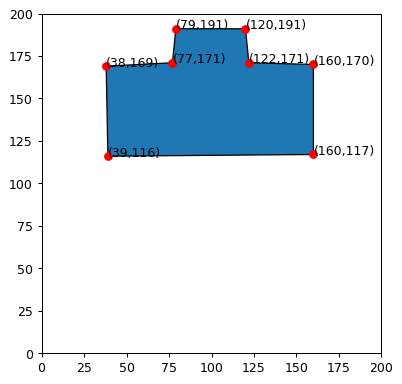

In [155]:
plot_svg([eight_sided_polygons[3]])

In [179]:
pair = [1,2,3]

In [180]:
lengths_average = np.zeros(8)
angles_average = np.zeros(9)

for pol_ct in pair:
    turning_lengths, turning_angles = turning_function_debug(eight_sided_polygons[pol_ct],True)
    lengths_average += np.array(turning_lengths)
    angles_average += np.array(turning_angles)

print(lengths_average/len(pair))
print(angles_average/len(pair))

[0.13788023 0.31426406 0.13785628 0.09767099 0.0516443  0.10870157
 0.0516443  0.10033827]
[271.06782502 360.46845753 450.         538.49256424 455.71059314
 540.         624.28940686 542.93567345 631.06782502]


In [ ]:
def turning_function_to_polygon(turn_lengths,turn_angles):
    

In [176]:
len(turning_angles)

9

In [ ]:
turning_function_average = turnings

## Extra code

In [326]:
# #Plot the data and PDF of fitted normal dist
# data = len1s
# plt.hist(data, bins=25, normed=True, alpha=0.6, color='g')
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)

# plt.show()